CHUAN BI DU LIEU VA XAY DUNG MO HINH REGRESSION

In [28]:
# Chia train/test với các tỉ lệ khác nhau
train_test_splits = [
    (0.8, 0.2),  # 4:1
    (0.7, 0.3),  # 7:3
    (0.6, 0.4)   # 6:4
]

# Lưu kết quả
results_regression = {
    'split': [],
    'model': [],
    'data_type': [],
    'mse': [],
    'rmse': [],
    'mae': [],
    'r2': []
}

THUC HIEN HOI QUY VOI NHIEU MO HINH KHAC NHAU

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
# Load dataset
data = pd.read_csv('../data/raw/IBM_HR_Analytics.csv')
print("✓ Dataset loaded successfully!")

✓ Libraries imported successfully!
Pandas version: 2.0.3
NumPy version: 1.24.3
✓ Dataset loaded successfully!


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import json
import time

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")

# Load data
df = pd.read_csv('../data/processed/data_normalized.csv')
print(f"✓ Data loaded: {df.shape}")

# Load metadata
with open('../data/processed/metadata.json', 'r') as f:
    metadata = json.load(f)

target_col = metadata['target_column']
print(f"✓ Target variable: {target_col}")

# Separate features and target
y = df[target_col].values
X = df.drop(target_col, axis=1).values
feature_names = df.drop(target_col, axis=1).columns.tolist()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {len(feature_names)}")

✓ Libraries imported successfully!
✓ Data loaded: (1470, 48)
✓ Target variable: JobSatisfaction

Features shape: (1470, 47)
Target shape: (1470,)
Number of features: 47


In [31]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

def train_and_evaluate_regression(X_train, X_test, y_train, y_test,
                                 model_name, data_type, split_ratio):
    """
    Train và evaluate regression model
    """
    # Khởi tạo models
    models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
    }

    model = models[model_name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Lưu kết quả
    results_regression['split'].append(split_ratio)
    results_regression['model'].append(model_name)
    results_regression['data_type'].append(data_type)
    results_regression['mse'].append(mse)
    results_regression['rmse'].append(rmse)
    results_regression['mae'].append(mae)
    results_regression['r2'].append(r2)

    return model, y_pred
# Chạy experiments
for train_size, test_size in train_test_splits:
    split_ratio = f"{int(train_size*10)}:{int(test_size*10)}"

    # Với dữ liệu gốc
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    for model_name in ['Linear Regression', 'Ridge', 'KNN', 'MLP']:
        train_and_evaluate_regression(
            X_train, X_test, y_train, y_test,
            model_name, 'Original', split_ratio
        )

    # Với dữ liệu giảm chiều (PCA)
    n_components = X.shape[1] // 3  # 1/3 số chiều
    pca_reduced = PCA(n_components=n_components)
    X_pca_reduced = pca_reduced.fit_transform(X)

    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        X_pca_reduced, y, test_size=test_size, random_state=42
    )

    for model_name in ['Linear Regression', 'Ridge', 'KNN', 'MLP']:
        train_and_evaluate_regression(
            X_train_pca, X_test_pca, y_train, y_test,
            model_name, 'PCA_Reduced', split_ratio
        )

SO SANH KET QUA CAC MO HINH HOI QUY

\n=== KẾT QUẢ HỒI QUY ===
   split              model    data_type       mse      rmse       mae        r2
0    8:2  Linear Regression     Original  1.302431  1.141241  0.958335 -0.030283
1    8:2              Ridge     Original  1.301879  1.140999  0.958100 -0.029846
2    8:2                KNN     Original  1.551293  1.245509  1.040816 -0.227144
3    8:2                MLP     Original  2.350938  1.533277  1.231146 -0.859700
4    8:2  Linear Regression  PCA_Reduced  1.266820  1.125531  0.960461 -0.002113
5    8:2              Ridge  PCA_Reduced  1.266810  1.125527  0.960465 -0.002105
6    8:2                KNN  PCA_Reduced  1.591701  1.261626  1.074150 -0.259108
7    8:2                MLP  PCA_Reduced  2.637308  1.623979  1.326694 -1.086232
8    7:3  Linear Regression     Original  1.270245  1.127051  0.961292 -0.020466
9    7:3              Ridge     Original  1.269667  1.126795  0.961094 -0.020002
10   7:3                KNN     Original  1.519728  1.232772  1.039002 -0.220891
11

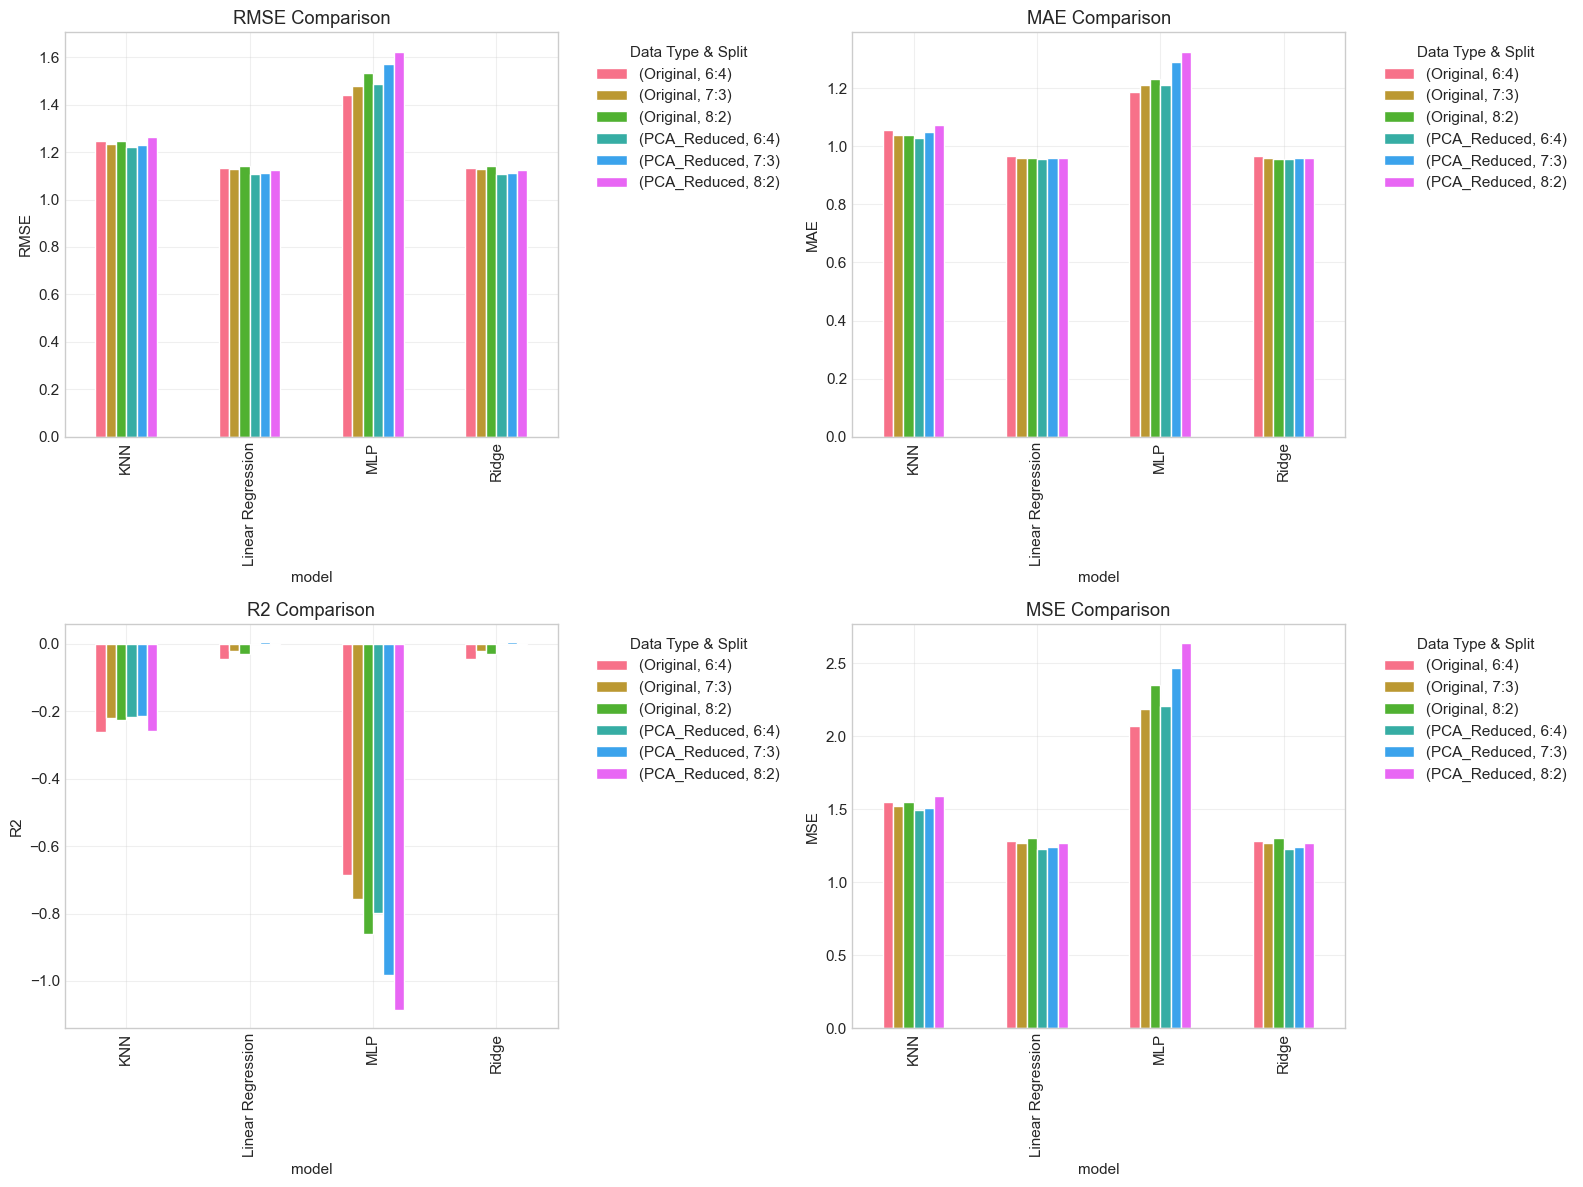

In [32]:
# Tạo DataFrame kết quả
results_df = pd.DataFrame(results_regression)
print("\\n=== KẾT QUẢ HỒI QUY ===")
print(results_df.to_string())

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['rmse', 'mae', 'r2', 'mse']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    pivot_table = results_df.pivot_table(
        values=metric,
        index='model',
        columns=['data_type', 'split'],
        aggfunc='mean'
    )
    pivot_table.plot(kind='bar', ax=ax)
    ax.set_title(f'{metric.upper()} Comparison')
    ax.set_ylabel(metric.upper())
    ax.legend(title='Data Type & Split', bbox_to_anchor=(1.05, 1))
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

PHAN TICH RESIDUALS

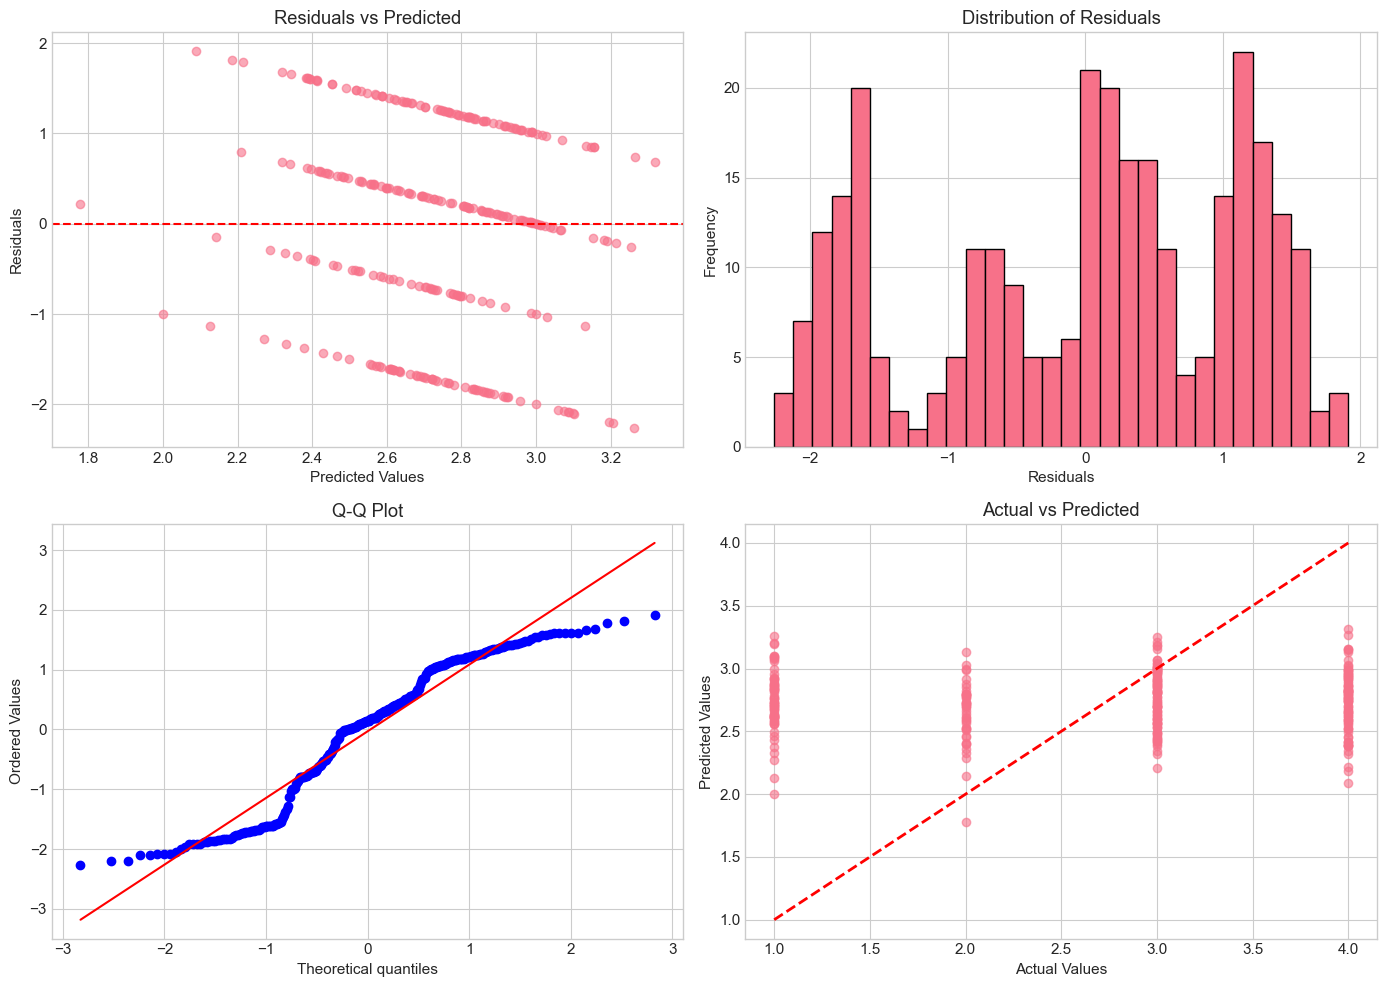

In [33]:
# Lấy model tốt nhất để phân tích residuals
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = Ridge(alpha=1.0)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

residuals = y_test - y_pred

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_pred, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted')

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Residuals')

# 3. Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. Actual vs Predicted
axes[1, 1].scatter(y_test, y_pred, alpha=0.6)
axes[1, 1].plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Actual vs Predicted')

plt.tight_layout()
plt.show()